In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.cluster import hierarchy
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data.csv")
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
# Feature Engineering

In [4]:
df.rename(columns={"child_mort": "Child Mortality", "exports": "Exports", "health": "Health", "imports": "Imports",
                  "income": "Income", "inflation": "Inflation", "life_expec": "Life Expectancy", "total_fer": "Fertility",
                  "gdpp": "GDP", "country": "Country"}, inplace=True)
Y = df['Country']
X = df.drop(columns=['Country'])
df

,Country,Child Mortality,Exports,Health,Imports,Income,Inflation,Life Expectancy,Fertility,GDP
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [5]:
# Splitting the data

In [6]:
# Custom implementation of train-test split that ensures all labels appear in the training set
# ( x_train and y_train contain all the data and x_test and, y_test contain a subset of the data with the specified split ratio.)
def custom_train_test_split(X, y, test_size=0.2, random_seed=42):
    
    X = np.array(X)
    y = np.array(y)
    np.random.seed(random_seed)
    
    n_samples = len(y)
    n_test = max(1, int(n_samples * test_size))  # Ensure at least one test sample
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    test_indices = indices[:n_test]
    train_indices = indices[:]  # All indices for training

    x_train = X[train_indices]
    y_train = y[train_indices]
    x_test = X[test_indices]
    y_test = y[test_indices]

    return x_train, x_test, y_train, y_test

# Split the dataset
x_train, x_test, y_train, y_test = custom_train_test_split(X, Y, test_size=0.5, random_seed=42)

# Check the shapes
print("Shape of X_train:", x_train.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)

Shape of X_train: (167, 9)
Shape of X_test: (83, 9)
Shape of Y_train: (167,)
Shape of Y_test: (83,)


In [7]:
# Feature Scaling (Z score)

In [8]:
# Standardization for X
X_train_mean = x_train.mean(axis=0)
X_train_std = x_train.std(axis=0)

# Avoid division by zero in case of zero standard deviation
X_train_std = np.where(X_train_std == 0, 1, X_train_std)

# Standardize training data
x_train_standardized = (x_train - X_train_mean) / X_train_std

# Standardize test data using training parameters
x_test_standardized = (x_test - X_train_mean) / X_train_std

# Ensure correct shapes
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Check the shapes
print("Shape of X_train_standardized:", x_train_standardized.shape)
print("Shape of X_test_standardized:", x_test_standardized.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)

Shape of X_train_standardized: (167, 9)
Shape of X_test_standardized: (83, 9)
Shape of Y_train: (167, 1)
Shape of Y_test: (83, 1)


In [9]:
# kNN Model

In [10]:
class kNN:
    # k-Nearest Neighbors (kNN) with Euclidean Distance
    def __init__(self, k=3):
        # Initialize the kNN model with k neighbors.
        self.k = k

    def euclidean(self, v1, v2):
        # Calculate Euclidean distance between two points.
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def fit(self, X_train_standardized, Y_train):
        # Store the training data.
        self.X_train_standardized = X_train_standardized
        self.Y_train = Y_train

        # Ensure k is not greater than the number of training samples
        if self.k > len(Y_train):
            raise ValueError(f"k={self.k} is greater than the number of training samples ({len(Y_train)}).")

    def predict(self, X_test_standardized):
        preds = []
        for test_row in X_test_standardized:
            nearest_neighbors = self.get_neighbors(test_row)
            majority_label = max(set(nearest_neighbors), key=nearest_neighbors.count)
            preds.append(majority_label)
        return np.array(preds)

    def get_neighbors(self, test_row):
        # Find the k nearest neighbors of a test point.
        distances = []
        for train_row, train_label in zip(self.X_train_standardized, self.Y_train):
            dist = self.euclidean(train_row, test_row)
            distances.append((dist, train_label))  # Ensure train_label is scalar

        distances.sort(key=lambda x: x[0])
        # Extract k nearest labels, ensuring k does not exceed available distances
        k_neighbors = min(self.k, len(distances))
        neighbors = [distances[i][1] for i in range(k_neighbors)]
        return neighbors
        
# Function to calculate accuracy
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()

In [11]:
# Ensure y_train and y_test is 1D
y_train = y_train.ravel()
y_test = y_test.ravel()

# Initialize and train
clf = kNN(k=3)
clf.fit(x_train_standardized, y_train)

# Predict on test set (not training set)
preds = clf.predict(x_test_standardized)  # Changed from x_train_standardized to x_test_standardized
print(f'Accuracy: {accuracy(preds, y_test):.3f} %')

# Let's also look at some predictions vs actuals
print("\nSample predictions vs actuals:")
for pred, actual in zip(preds[:5], y_test[:5]):
    print(f"Predicted: {pred:20} Actual: {actual}")

Accuracy: 34.940 %

Sample predictions vs actuals:
Predicted: Kiribati             Actual: Micronesia, Fed. Sts.
Predicted: Namibia              Actual: Namibia
Predicted: Jordan               Actual: Jordan
Predicted: Senegal              Actual: Gambia
Predicted: Malta                Actual: Malta


In [12]:
# K-Means Model

In [13]:
class Kmeans:
    """
    K-Means clustering algorithm implementation.

    Parameters:
        K (int): Number of clusters

    Attributes:
        K (int): Number of clusters
        centroids (numpy.ndarray): Array containing the centroids of each cluster

    Methods:
        __init__(self, K): Initializes the Kmeans instance with the specified number of clusters.
        initialize_centroids(self, X): Initializes the centroids for each cluster by selecting K random points from the dataset.
        assign_points_centroids(self, X): Assigns each point in the dataset to the nearest centroid.
        compute_mean(self, X, points): Computes the mean of the points assigned to each centroid.
        fit(self, X, iterations=10): Clusters the dataset using the K-Means algorithm.
    """
    
    def __init__(self, K):
        assert K > 0, "K should be a positive integer."
        self.K = K
        
    def initialize_centroids(self, X):
        assert X.shape[0] >= self.K, "Number of data points should be greater than or equal to K."
        
        randomized_X = np.random.permutation(X.shape[0]) 
        centroid_idx = randomized_X[:self.K] # get the indices for the centroids
        self.centroids = X[centroid_idx] # assign the centroids to the selected points
        
    def assign_points_centroids(self, X):
        """
        Assign each point in the dataset to the nearest centroid.
        
        Parameters:
        X (numpy.ndarray): dataset to cluster
        
        Returns:
        numpy.ndarray: array containing the index of the centroid for each point
        """
        X = np.expand_dims(X, axis=1) # expand dimensions to match shape of centroids
        distance = np.linalg.norm((X - self.centroids), axis=-1) # calculate Euclidean distance between each point and each centroid
        points = np.argmin(distance, axis=1) # assign each point to the closest centroid
        assert len(points) == X.shape[0], "Number of assigned points should equal the number of data points."
        return points
    
    def compute_mean(self, X, points):
        """
        Compute the mean of the points assigned to each centroid.
        
        Parameters:
        X (numpy.ndarray): dataset to cluster
        points (numpy.ndarray): array containing the index of the centroid for each point
        
        Returns:
        numpy.ndarray: array containing the new centroids for each cluster
        """
        centroids = np.zeros((self.K, X.shape[1])) # initialize array to store centroids
        for i in range(self.K):
            centroid_mean = X[points == i].mean(axis=0) # calculate mean of the points assigned to the current centroid
            centroids[i] = centroid_mean # assign the new centroid to the mean of its points
        return centroids
    
    def fit(self, X, iterations=10):
        """
        Cluster the dataset using the K-Means algorithm.
    
        Parameters:
        X (array-like): Dataset to cluster.
        iterations (int): Number of iterations to perform (default=10).
    
        Returns:
        numpy.ndarray: Array containing the final centroids for each cluster.
        numpy.ndarray: Array containing the index of the centroid for each point.
        """
        X = np.array(X)  # Convert X to a NumPy array if it is not already
        self.initialize_centroids(X)  # Initialize the centroids
        for i in range(iterations):
            points = self.assign_points_centroids(X)  # Assign each point to the nearest centroid
            self.centroids = self.compute_mean(X, points)  # Compute the new centroids based on the mean of their points

            # Assertions for debugging and validation
            assert len(self.centroids) == self.K, "Number of centroids should equal K."
            assert X.shape[1] == self.centroids.shape[1], "Dimensionality of centroids should match input data."
            assert max(points) < self.K, "Cluster index should be less than K."
            assert min(points) >= 0, "Cluster index should be non-negative."

        return self.centroids, points

In [14]:
X = X.values  # Convert DataFrame to NumPy array
kmeans = Kmeans(3)
centroids, points = kmeans.fit(X, 1000) # K-Means for 1000 iterations

In [15]:
# Visualization of Clusters

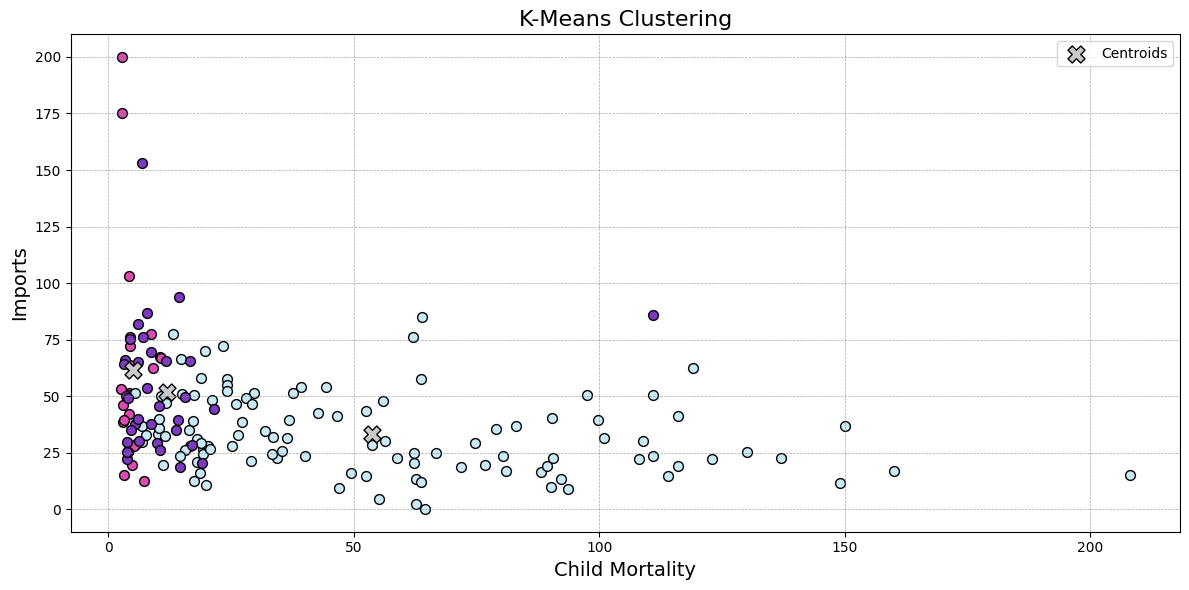

In [16]:
# Define colors for the clusters
colors = ['#DB4CB2', '#c9e9f6', '#7D3AC1']
centroid_color = '#CAC9CD'

# Create the figure and plot
plt.figure(figsize=(12, 6))

# Plot each cluster
for i, color in enumerate(colors):
    cluster_points = X[points == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=color, edgecolor='k', s=50)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], 
            c=centroid_color, label='Centroids', 
            edgecolor='k', s=150, marker='X')

# Customize the plot
plt.title('K-Means Clustering', fontsize=16)
plt.xlabel('Child Mortality', fontsize=14)
plt.ylabel('Imports', fontsize=14)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Hierarchical Clustering Model

In [18]:
import numpy as np

class HC:
    def __init__(self, verbose=False, linkage_type='complete'):
        self.verbose = verbose
        self.linkage_type = linkage_type

    def argmin(self, D):
        """
        Given a 2D array, returns the minimum value that is not in the main diagonal, i.e where x = y
        and (x,y) index of that value.
        """
        minx, miny = (0, 0)
        min_val = float('inf')
        for i in range(D.shape[0]):
            for j in range(D.shape[0]):
                if j == i:
                    continue
                if D[i, j] < min_val:
                    min_val = D[i, j]
                    minx = i
                    miny = j

        return min_val, minx, miny

    def compute_euclidean_distances(self, X1, X2):
        """
        Compute pairwise Euclidean distances between two sets of points.

        Parameters:
        X1, X2: numpy.ndarray
            Input data arrays of shape (n_samples_1, n_features) and (n_samples_2, n_features).

        Returns:
        distances: numpy.ndarray
            Pairwise distances of shape (n_samples_1, n_samples_2).
        """
        distances = np.sqrt(((X1[:, np.newaxis, :] - X2[np.newaxis, :, :]) ** 2).sum(axis=2))
        return distances

    def cluster_distance(self, cluster_members, X):
        """
        Calculates the cluster Euclidean distances. 
        
        Params
        ------
        cluster_members: dict.
            Stores the cluster members in format: {key: [item1, item2 ..]}. 
            If key is less than X.shape[0], then it only has itself in the cluster. 
        
        Returns
        -------
        Distance: 2D array. 
            Contains distances between each cluster. 
        """
        n_clusters = len(cluster_members)
        keys = list(cluster_members.keys())
        distances = np.zeros((n_clusters, n_clusters))

        for i in range(n_clusters):
            ith_elems = cluster_members[keys[i]]

            for j in range(n_clusters):
                jth_elems = cluster_members[keys[j]]
                pairwise_distances = self.compute_euclidean_distances(X[ith_elems], X[jth_elems])

                if self.linkage_type == 'complete':
                    dij = np.max(pairwise_distances)
                elif self.linkage_type == 'single':
                    dij = np.min(pairwise_distances)
                distances[i, j] = dij

        return distances

    def fit(self, X):
        """
        Generates the dendrogram.
        
        Params
        ------
        X: Dataset, shape (n_samples, n_features)
        
        Returns
        -------
        Z: 2D array. shape (n_samples-1, 4). 
            Linkage matrix. Stores the merge information at each iteration.
        """
        self.n_samples = X.shape[0]
        cluster_members = {i: [i] for i in range(self.n_samples)}
        Z = np.zeros((self.n_samples - 1, 4))

        for i in range(self.n_samples - 1):
            if self.verbose:
                print(f'\n-------\nDebug Line at, i={i}\n--------')

            n_clusters = len(cluster_members)
            keys = list(cluster_members.keys())

            D = self.cluster_distance(cluster_members, X)
            _, tmpx, tmpy = self.argmin(D)

            x = keys[tmpx]
            y = keys[tmpy]

            Z[i, 0] = x
            Z[i, 1] = y
            Z[i, 2] = D[tmpx, tmpy]
            Z[i, 3] = len(cluster_members[x]) + len(cluster_members[y])

            cluster_members[self.n_samples + i] = cluster_members[x] + cluster_members[y]

            del cluster_members[x]
            del cluster_members[y]

        self.Z = Z
        return self.Z

    def predict(self, n_cluster=3):
        """
        Get cluster label for specific cluster size.
        
        Params
        ------
        n_cluster: int. 
            Number of clusters to keep. Can not be > n_samples
        
        Returns
        -------
        labels: list.
            Cluster labels for each sample.
        """
        labels = np.zeros((self.n_samples))
        cluster_members = {i: [i] for i in range(self.n_samples)}

        for i in range(self.n_samples - n_cluster):
            x, y = int(self.Z[i, 0]), int(self.Z[i, 1])
            cluster_members[self.n_samples + i] = cluster_members[x] + cluster_members[y]

            del cluster_members[x]
            del cluster_members[y]

        keys = list(cluster_members.keys())

        for i in range(len(keys)):
            samples_in_cluster = cluster_members[keys[i]]
            labels[samples_in_cluster] = i

        return labels

In [19]:
hc = HC(linkage_type='complete')
Z = hc.fit(X)
myLabel = hc.predict(n_cluster=3)

In [20]:
# Visualization of Cluster and Dendogram (to find the optimal number of clusters)

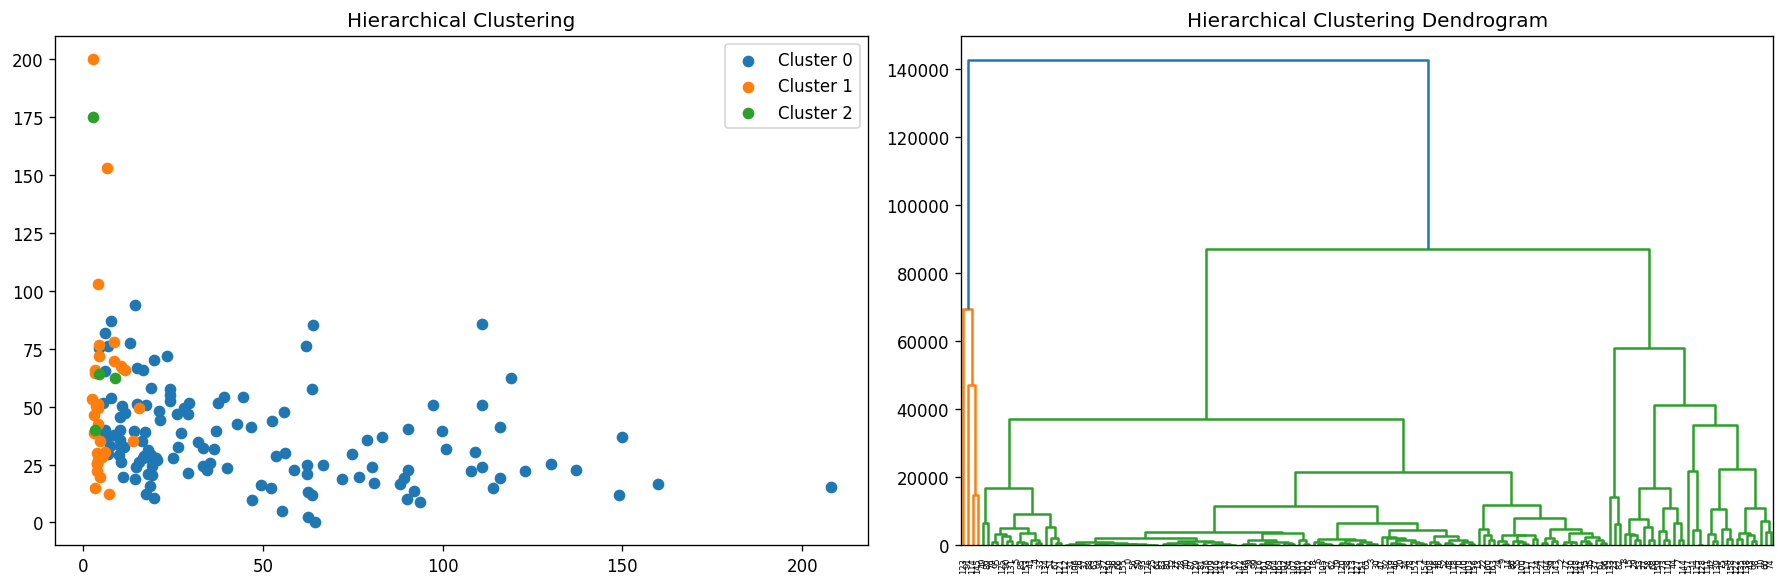

In [21]:
fig, ax = plt.subplots(1, 2, facecolor='white', figsize=(15, 5), dpi=120)

# Cluster representation using the custom implementation
for i in range(3):
    myIndices = myLabel == i
    ax[0].scatter(X[myIndices, 0], X[myIndices, 1], label=f'Cluster {i}')

ax[0].set_title('Hierarchical Clustering')
ax[0].legend()

# Dendrogram representation using the custom linkage matrix
hierarchy.dendrogram(Z, ax=ax[1])  # Using scipy's dendrogram function with custom linkage
ax[1].set_title('Hierarchical Clustering Dendrogram')

plt.tight_layout()
plt.show()